# Import and declaring certain arguments

In [15]:
# coding: utf-8
import argparse
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import data
import model
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:

class Args:
  data = './data/wikitext-2'
  model = 'FNNModel'
  emsize = 200
  context_size = 8
  nhid = 200
  nlayers = 2
  lr = 20
  clip = 0.25
  epochs = 40
  batch_size = 8
  bptt = 35
  dropout = 0.2
  tied = True
  seed = 1111
  cuda = True
  log_interval = 200
  save = 'model.pt'
  onnx_export = ''
  nhead = 2
  dry_run =  True

args=Args()

In [43]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")



# Loading the data

In [44]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args.data)

# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.


In [50]:
print(corpus.train)

tensor([ 0,  1,  2,  ..., 15,  0,  0])


In [5]:
# we want to return a tensor with ascending batch 

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(-1, bsz).contiguous()
    return data.to(device)

eval_batch_size = 8
train_data = batchify(corpus.train, args.batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [95]:
def batchify(data, bsz):
    x=[]
    y=[]
    data = data.numpy()
    for i,word in enumerate(data):
        if i+bsz>= len(data):
            # sentence boundary reached
            # ignoring sentence less than 3 words
            break
        # convert word to id
        x_extract = []
        for j in range(bsz):
            x_extract.append(data[i+j])
        y_extract = [data[i+bsz]]
        x.append(x_extract)
        y.append(y_extract)
    x = torch.IntTensor(x)
    y=torch.IntTensor(y)
    return x, y

In [96]:
x,y = batchify(corpus.train, args.batch_size)

In [102]:
print(x[1])
print(x[2088619])
print(y[2088619])
print(x.size())
print(y.size())

tensor([1, 2, 3, 4, 1, 0, 0, 5], dtype=torch.int32)
tensor([ 209, 3083,   23,  147, 2234, 2112,   15,    0], dtype=torch.int32)
tensor([0], dtype=torch.int32)
torch.Size([2088620, 8])
torch.Size([2088620, 1])


In [79]:
data1 = corpus.train
print(data1.size(0))

2088628


In [60]:
print(train_data[0])

[[tensor(5), tensor(6), tensor(2), tensor(7), tensor(8), tensor(9), tensor(3), tensor(10)]]


# Declaring data loader functions 

In [6]:
# get the train and target for the train values
def get_batch(source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len]
    target = target.narrow(1,0,1).contiguous().view(-1)
    return data, target

In [7]:
data, target = get_batch(val_data, 0)

In [8]:
print(data)

tensor([[    0,     1, 32966, 32967,     1,     0,     0, 32966],
        [32967,    13,   406,    23,    17,  6253, 19902,   310],
        [ 1444, 19902,    13,    26,    27,  2576,    16,     9],
        [19902,   115,    17,  4929,  4121,  9611,    13,  4854],
        [ 2429,    37,   651,    16,    17,   989,  2429,    15],
        [  135,    26,  2763,   258,    22,    17,  1204, 19902],
        [   13,  1796, 25170,    15,   135,  1575,  5357,    22],
        [   27,   958,    16,  6318,  2584,    10,  2099,    43],
        [   19,    37,    27,  4235,    16,  1326, 13129,    10],
        [ 2034, 17346,    19,    13,    37,  2736,    27, 14429],
        [ 1660,    16, 19195,    15,   652,  1127,    13,    17],
        [19908,    78,  5710,    13,   278,  2765,    61, 19902],
        [ 5706,    61,    93, 14706,    15, 24805,   234,    43],
        [   17,   983,    13,  2624, 15743,   321,    78,   265],
        [   35,    17,  2623,    39,   423,    22,    27,   152],
        [ 

In [9]:
print(target)

tensor([32967,  1444, 19902,  2429,   135,    13,    27,    19,  2034,  1660,
        19908,  5706,    17,    35,   745,    26,  1253,    17,  2712,    27,
          423,    37,    10,    17,   831,    43,  1839,  1305,   625,     9,
         5357,     9,    27,    22,  1803], device='cuda:0')


# Building the model

In [10]:
# creating our FNN model 

# Trigram Neural Network Model
class FNNModel(nn.Module):
    # Here context_size should be 8( because its 8 gram model ), embedding dimension is 200, h is number of hidden layers , can set it to 200
    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(FNNModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        # Linear 2 is the decoder that returns a variable based on vocab size 
        self.linear2 = nn.Linear(h, vocab_size, bias = False)

    def forward(self, inputs):
        # compute x': concatenation of all the 8 words in 8 gram model 
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # compute h: tanh(W_1.x' + b)
        out = torch.tanh(self.linear1(embeds))
        # compute W_2.h
        out = self.linear2(out)
        # compute y: log_softmax(W_2.h)
        log_probs = torch.nn.functional.log_softmax(out, dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return log_probs

# Declaring the helper functions  

In [11]:
# helper function to get accuracy from log probabilities
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc



# helper function to evaluate model on dev data
def evaluate(model, criterion, data_source):
    model.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(range(0, data_source.size(0) - 1, args.bptt)):
            context_tensor, target_tensor = get_batch(data_source, data_tensor)
#             context_tensor = data_tensor[:,0:2]
#             target_tensor = data_tensor[:,2]
            context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
            log_probs = model(context_tensor)
            mean_loss += criterion(log_probs, target_tensor).item()
            mean_acc += get_accuracy_from_log_probs(log_probs, target_tensor)
            count += 1
            if it % 500 == 0: 
                print("Dev Iteration {} complete. Mean Loss: {}; Mean Acc:{}; Time taken (s): {}".format(it, mean_loss / count, mean_acc / count, (time.time()-dev_st)))
                dev_st = time.time()

    return mean_acc / count, mean_loss / count


# Training the model and evaluating on val set

In [33]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
ntokens = len(corpus.dictionary)
model = FNNModel(ntokens, args.emsize, args.context_size, args.nhid).to(device)

# # load it to gpu
# model.cuda(gpu)

# using ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)


# ------------------------- TRAIN & SAVE MODEL ------------------------
best_acc = 0
best_model_path = None
loss_values=[]
ppl_values=[]
for epoch in range(5):
    st = time.time()
    running_loss = 0.0
    running_ppl =0.0
    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(range(0, train_data.size(0) - 1, args.bptt)):       
        # context_tensor = data_tensor[:,0:2]
        # target_tensor = data_tensor[:,2]
        context_tensor, target_tensor= get_batch(train_data, data_tensor)

        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probs(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()
        running_loss =+ loss.item()
        running_ppl =+ math.exp(loss.item())

        if it % 500 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}| ppl {:8.2f}".format(it, epoch, loss.item(), acc, (time.time()-st),  math.exp(loss.item())))
            st = time.time()
    total_runs = (train_data.size(0) - 1)/(args.bptt)
    loss_values.append(running_loss / total_runs)
    ppl_values.append(running_ppl / total_runs)
    print("\n--- Evaluating model on dev data ---")
    dev_acc, dev_loss = evaluate(model, loss_function, val_data)
    print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(epoch, dev_acc, dev_loss))
    if dev_acc > best_acc:
        print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        # set best model path


        
#         best_model_path = 'best_model_{}.dat'.format(epoch)
#         # saving best model
#         torch.save(model.state_dict(), best_model_path)


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 10.475489616394043; Acc:0.0; Time taken (s): 0.01999974250793457| ppl 35436.22
Training Iteration 500 of epoch 0 complete. Loss: 7.927534580230713; Acc:0.05714285746216774; Time taken (s): 9.917526960372925| ppl  2772.58
Training Iteration 1000 of epoch 0 complete. Loss: 7.623171329498291; Acc:0.05714285746216774; Time taken (s): 9.886016368865967| ppl  2045.04
Training Iteration 1500 of epoch 0 complete. Loss: 7.381105899810791; Acc:0.08571428805589676; Time taken (s): 9.878983497619629| ppl  1605.36
Training Iteration 2000 of epoch 0 complete. Loss: 7.380171298980713; Acc:0.17142857611179352; Time taken (s): 9.873000621795654| ppl  1603.86
Training Iteration 2500 of epoch 0 complete. Loss: 7.771772861480713; Acc:0.08571428805589676; Time taken (s): 9.797998666763306| ppl  2372.67
Training Iteration 3000 of epoch 0 complete. Loss: 8.250960350036621; Acc:0.17142857611179352; Time taken (s): 9.8300034999847

Training Iteration 1500 of epoch 3 complete. Loss: 4.771848201751709; Acc:0.1428571492433548; Time taken (s): 9.823998212814331| ppl   118.14
Training Iteration 2000 of epoch 3 complete. Loss: 4.3330864906311035; Acc:0.1428571492433548; Time taken (s): 9.806999683380127| ppl    76.18
Training Iteration 2500 of epoch 3 complete. Loss: 4.1960930824279785; Acc:0.20000000298023224; Time taken (s): 9.80699872970581| ppl    66.43
Training Iteration 3000 of epoch 3 complete. Loss: 4.652804374694824; Acc:0.17142857611179352; Time taken (s): 9.810999155044556| ppl   104.88
Training Iteration 3500 of epoch 3 complete. Loss: 5.601353645324707; Acc:0.11428571492433548; Time taken (s): 9.811997652053833| ppl   270.79
Training Iteration 4000 of epoch 3 complete. Loss: 4.019041061401367; Acc:0.3142857253551483; Time taken (s): 9.804999589920044| ppl    55.65
Training Iteration 4500 of epoch 3 complete. Loss: 3.3556549549102783; Acc:0.4000000059604645; Time taken (s): 9.806999683380127| ppl    28.66
T

In [32]:
print(train_data.size(0) - 1)
print(args.bptt)
testa = (train_data.size(0) - 1)/(args.bptt)
print(testa)

261077
35
7459.342857142857


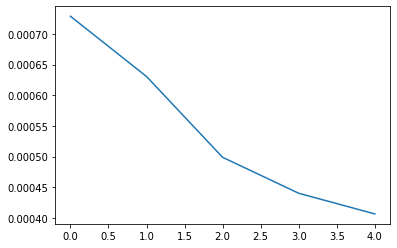

In [35]:
plt.plot(loss_values)